# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


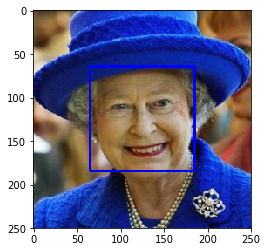

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

99% of the humans were detected as humans!
12% of the dogs were detected as humans!

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_count = sum([face_detector(human_image) for human_image in human_files_short])
dog_count = sum([face_detector(dog_image) for dog_image in dog_files_short])

print(str(human_count) + "% of the humans were detected as humans!")
print(str(dog_count) + "% of the dogs were detected as humans")

99% of the humans were detected as humans!
12% of the dogs were detected as humans


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__
The expectation that the user should provide images which provide a clear view of a face does seem reasonable from the Machine learning engineer’s point of view as it would make his/her work much easier. 

But in reality, it is not practical to impose any such conditions on the user. In the era of rapid development of Artificial intelligence, it becomes imperative that the algorithm should be made capable enough to identify whether the provided image is a human or dog(even if the provided image is blurred). In order to achieve this, we need to use deep neural network and its various methods. We should collect and maintain a repository of blurred images, extensively train the algorithm, add exhaustive filters to detect various patterns. We should also use the method of image augmenting on the training data so that we can identify an image irrespective of the size, angle, alignment etc.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [10]:
# Code to display the details in the graph

def display_graph(hist,title,xlabel,ylabel,field1,field2):

    plt.plot(hist.history[field1],color='blue')
    plt.plot(hist.history[field2],color='red')
    
    #Code to assign title,lable
    plt.title(title)   
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    #Code to assign legend
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    #Code to set grid as true
    plt.grid(True)
    
    #Code to display the graph
    plt.show()
    
    return

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
0% of the humans were detected as dogs
100% of the dogs were detected as dogs!

In [12]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_count = sum([dog_detector(human_image) for human_image in human_files_short])
dog_count = sum([dog_detector(dog_image) for dog_image in dog_files_short])

print(str(human_count) + "% of the humans were detected as dogs")
print(str(dog_count) + "% of the dogs were detected as dogs!")

0% of the humans were detected as dogs
100% of the dogs were detected as dogs!


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 136.08it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

Designing an architecture involves creating a sequence of convolution layers, various pooling layers. The code written below is basically a simple architecture with a stack of 3 convolution layers with a ReLu activation function, followed by 3 max-pooling layers. 

In line 2,4,6 : The convolutional layer is a stack of feature maps-one feature map for each filter.This is the first step of a CNN. We have also set numerous hyper parameters such as number of filters, size of our windows, activation function, the stride and the padding.ReLu activation helps us with vanishing gradients problem and to attain much better accuracy

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))

In line 3,5,7 : As the number of filters increase this leads to bigger stack and so the dimensionality might increase. Which in turn generates higher number of parameters and leads to overfitting. The method to reduce this dimensionality of our arrays can be achieved by adding pooling layer to the convolutional neural network. Here we are using Maxpooling function.

model.add(MaxPooling2D(pool_size=2))

The first few convolution layers detect spatial patterns in the image. These layers will be used to make the array deeper as it passes through the network and max pooling layers will be used to decrease the spatial dimension.The number of filters slowly increase in a sequence (16,32,64)

In line 8,11 : Dropout layer has been added to minimize overfitting

model.add(Dropout(0.3))

Line 9: We have reached a stage where the array can answer whether a particular feature is present or not. And no more spatial information is left to discover. At this stage we can Flatten the array to a vector. Flattening is the process of converting all the resultant 2 dimensional arrays into a single long continuous linear vector.We can feed it to one or more fully connected layers to determine what object is contained in the image.

model.add(Flatten())

Finally in the last layer, we have softmax activation function so that it returns probabilities.

model.add(Dense(133, activation='softmax'))

The CNNs have several different filters/kernels consisting of (randomly initialized) trainable parameters depending on the depth and filters at each layer of a network, which can convolve on a given input volume (the first input being the image itself) spatially to create some feature/activation maps at each layer. During this process, (through back-propagation) they learn by adjusting those initial values to capture the correct magnitude of a spatial feature on which they are convolving. These high number of filters essentially learn to capture spatial features from the input volumes based on the learned magnitude. Hence they can successfully boil down a given image into a highly abstracted representation which is easy for predicting.


In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,AveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
__________

### Compile the Model

In [15]:
#Code to compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [16]:
#Code to perform augmentation
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    rotation_range=40, # degree range for random rotations
    shear_range=0.2, # shear angle in counter-clockwise direction in degrees
    zoom_range=0.2, # range for random zoom
    width_shift_range=0.1,  # randomly shift images horizontally 
    height_shift_range=0.1,  # randomly shift images vertically 
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    rotation_range=40, # degree range for random rotations
    shear_range=0.2, # shear angle in counter-clockwise direction in degrees
    zoom_range=0.2, # range for random zoom
    width_shift_range=0.1,  # randomly shift images horizontally 
    height_shift_range=0.1,  # randomly shift images vertically 
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)

In [17]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

batch_size=20
epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

#Code to train the model on data generated batch-by-batch
hist=model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/10
 - 426s - loss: 4.8707 - acc: 0.0171 - val_loss: 4.5942 - val_acc: 0.0311

Epoch 00001: val_loss improved from inf to 4.59420, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/10
 - 431s - loss: 4.5320 - acc: 0.0365 - val_loss: 4.4294 - val_acc: 0.0455

Epoch 00002: val_loss improved from 4.59420 to 4.42945, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/10
 - 709s - loss: 4.3818 - acc: 0.0519 - val_loss: 4.3342 - val_acc: 0.0515

Epoch 00003: val_loss improved from 4.42945 to 4.33425, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/10
 - 776s - loss: 4.3057 - acc: 0.0599 - val_loss: 4.3740 - val_acc: 0.0503

Epoch 00004: val_loss did not improve from 4.33425
Epoch 5/10
 - 781s - loss: 4.2591 - acc: 0.0566 - val_loss: 4.2872 - val_acc: 0.0491

Epoch 00005: val_loss improved from 4.33425 to 4.28721, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 6/10
 - 806s - loss: 4.2293 - acc: 0.0650 - val_loss:

### Load the Model with the Best Validation Loss

In [18]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [19]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 10.1675%


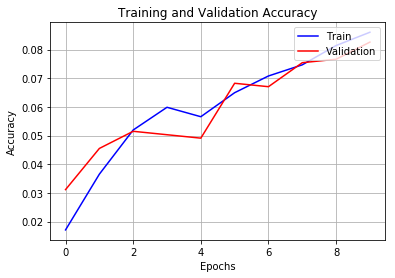

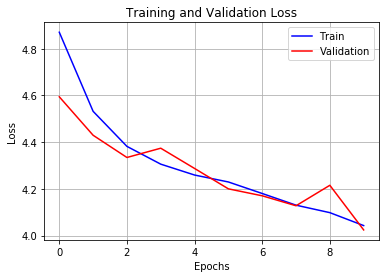

In [20]:
#Display Training and Validation Accuracy and Loss
display_graph(hist,'Training and Validation Accuracy','Epochs','Accuracy','acc','val_acc')
display_graph(hist,'Training and Validation Loss','Epochs','Loss','loss','val_loss')

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [21]:
#Code to obtain bottleneck features for VGG16
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [22]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [23]:
#Code to compile the model
optimizer ='sgd'
VGG16_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Train the Model

In [24]:
from keras.callbacks import ModelCheckpoint 

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

#Code to train the model for a given number epochs
VGG16_hist=VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=25, batch_size=20, callbacks=[checkpointer], verbose=0)


Epoch 00001: val_loss improved from inf to 9.16643, saving model to saved_models/weights.best.VGG16.hdf5

Epoch 00002: val_loss improved from 9.16643 to 8.03382, saving model to saved_models/weights.best.VGG16.hdf5

Epoch 00003: val_loss improved from 8.03382 to 7.32002, saving model to saved_models/weights.best.VGG16.hdf5

Epoch 00004: val_loss improved from 7.32002 to 7.27926, saving model to saved_models/weights.best.VGG16.hdf5

Epoch 00005: val_loss improved from 7.27926 to 7.19328, saving model to saved_models/weights.best.VGG16.hdf5

Epoch 00006: val_loss improved from 7.19328 to 7.11465, saving model to saved_models/weights.best.VGG16.hdf5

Epoch 00007: val_loss improved from 7.11465 to 6.94961, saving model to saved_models/weights.best.VGG16.hdf5

Epoch 00008: val_loss improved from 6.94961 to 6.82701, saving model to saved_models/weights.best.VGG16.hdf5

Epoch 00009: val_loss improved from 6.82701 to 6.71429, saving model to saved_models/weights.best.VGG16.hdf5

Epoch 00010: 

### Load the Model with the Best Validation Loss

In [25]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [26]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 54.7847%


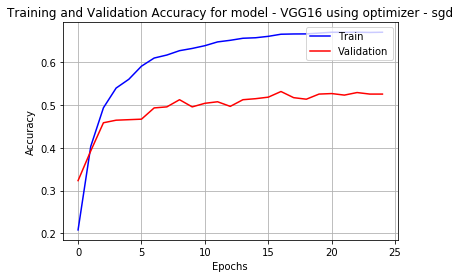

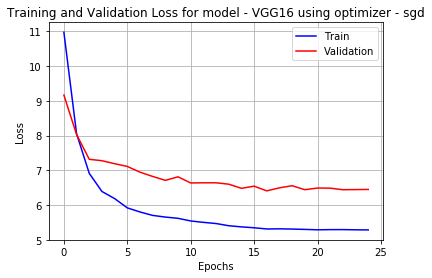

In [27]:
#Display Training and Validation Accuracy / Loss
graph1title = 'Training and Validation Accuracy for model - VGG16 using optimizer - '+str(optimizer)
graph2title = 'Training and Validation Loss for model - VGG16 using optimizer - '+str(optimizer)

display_graph(VGG16_hist,graph1title,'Epochs','Accuracy','acc','val_acc')
display_graph(VGG16_hist,graph2title,'Epochs','Loss','loss','val_loss')

### Predict Dog Breed with the Model

In [28]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

VGG16_predict_breed('images/Brittany_02625.jpg')

'Brittany'

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [29]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

# Various values that one can set for the network variable 
#['VGG19',ResNet50','InceptionV3','Xception']
#Code to assign a particular value to network variable
network = 'Xception' 
cnnpath = 'bottleneck_features/Dog' + network + 'Data.npz'

bottleneck_features_network = np.load(cnnpath)

#Code to assign bottleneck features to train,test and validation sets
train_network = bottleneck_features_network['train']
valid_network = bottleneck_features_network['valid']
test_network = bottleneck_features_network['test']

#Code to print the shape of train,test and validation sets
print("Shape of train_network: {}".format(train_network.shape))
print("Shape of valid_network: {}".format(valid_network.shape))
print("Shape of test_network: {}".format(test_network.shape))

Shape of train_network: (6680, 7, 7, 2048)
Shape of valid_network: (835, 7, 7, 2048)
Shape of test_network: (836, 7, 7, 2048)


Inception V3 Results obtained for optimizer - Rmsprop,SGD,Adam


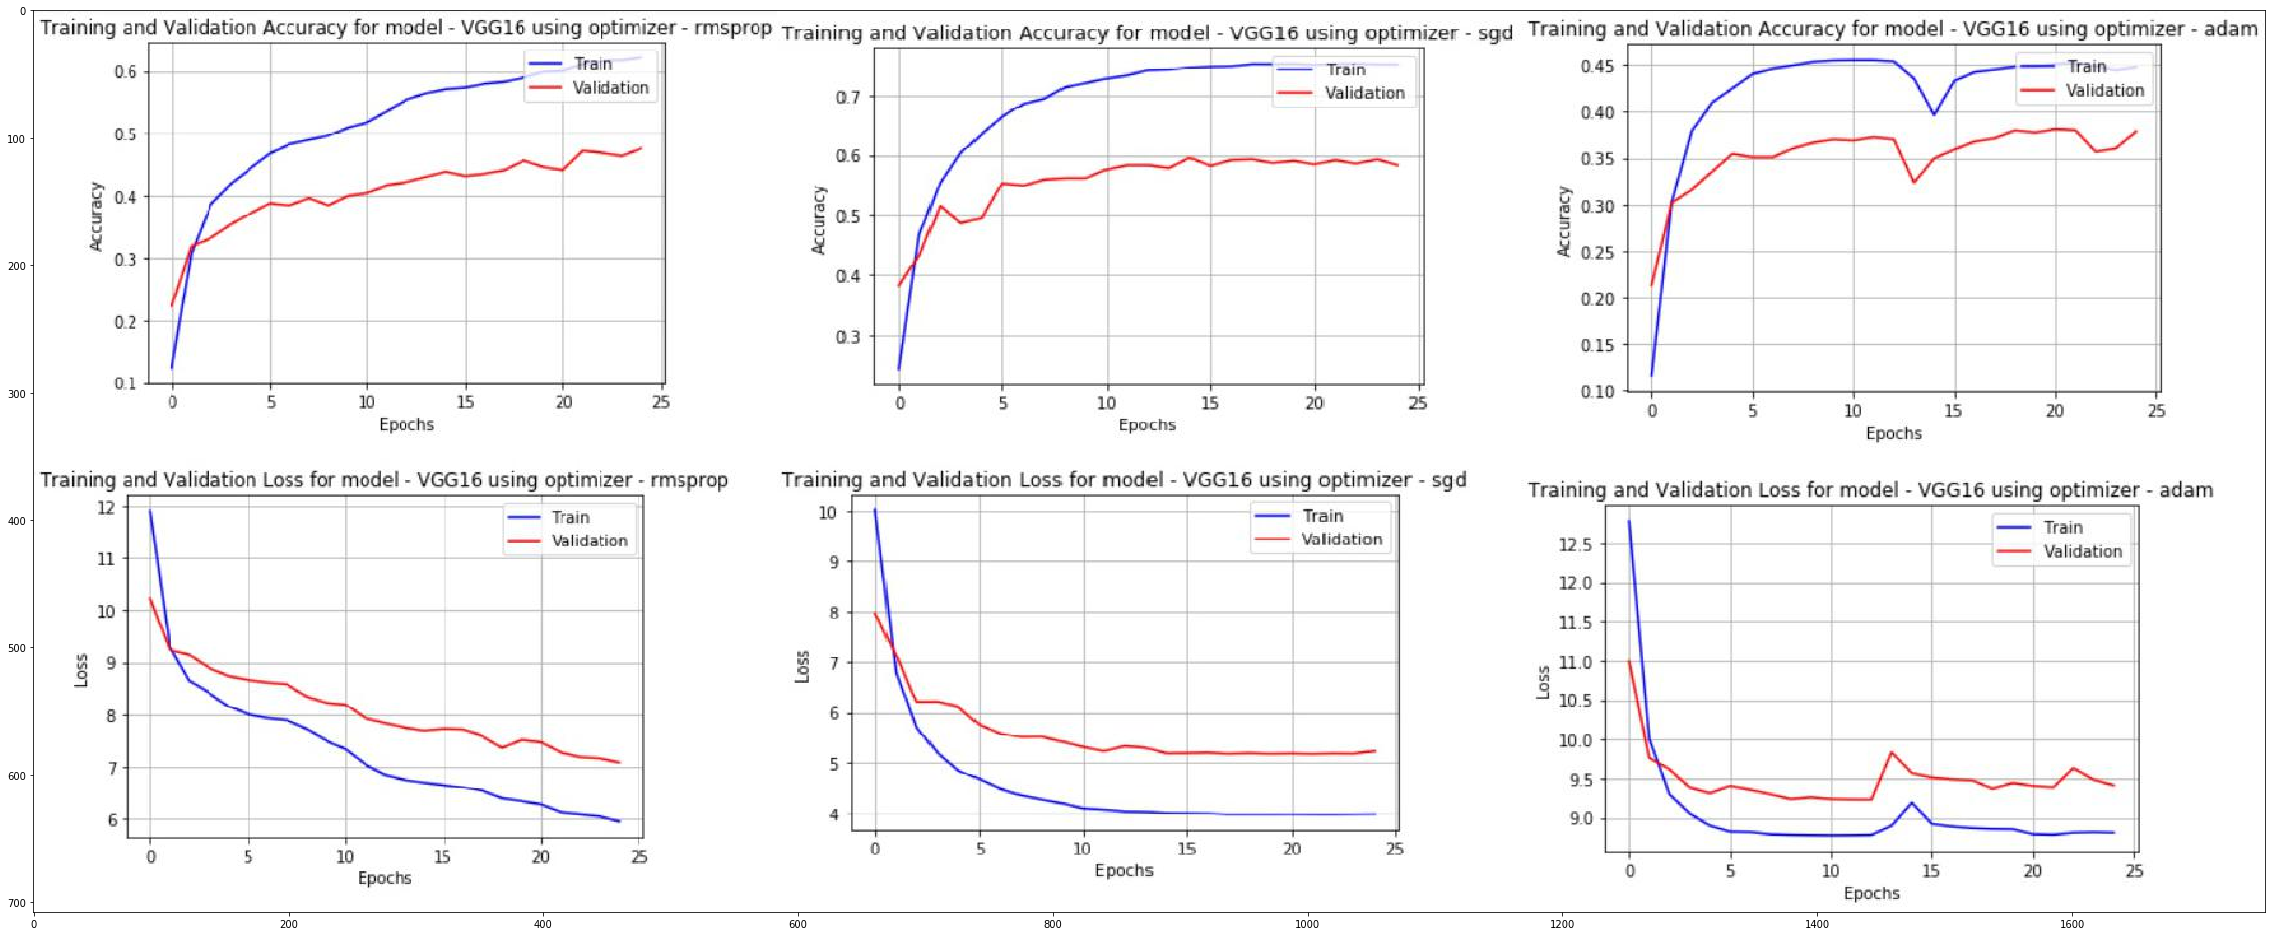

ResNet50 Results obtained for optimizer - Rmsprop,SGD,Adam


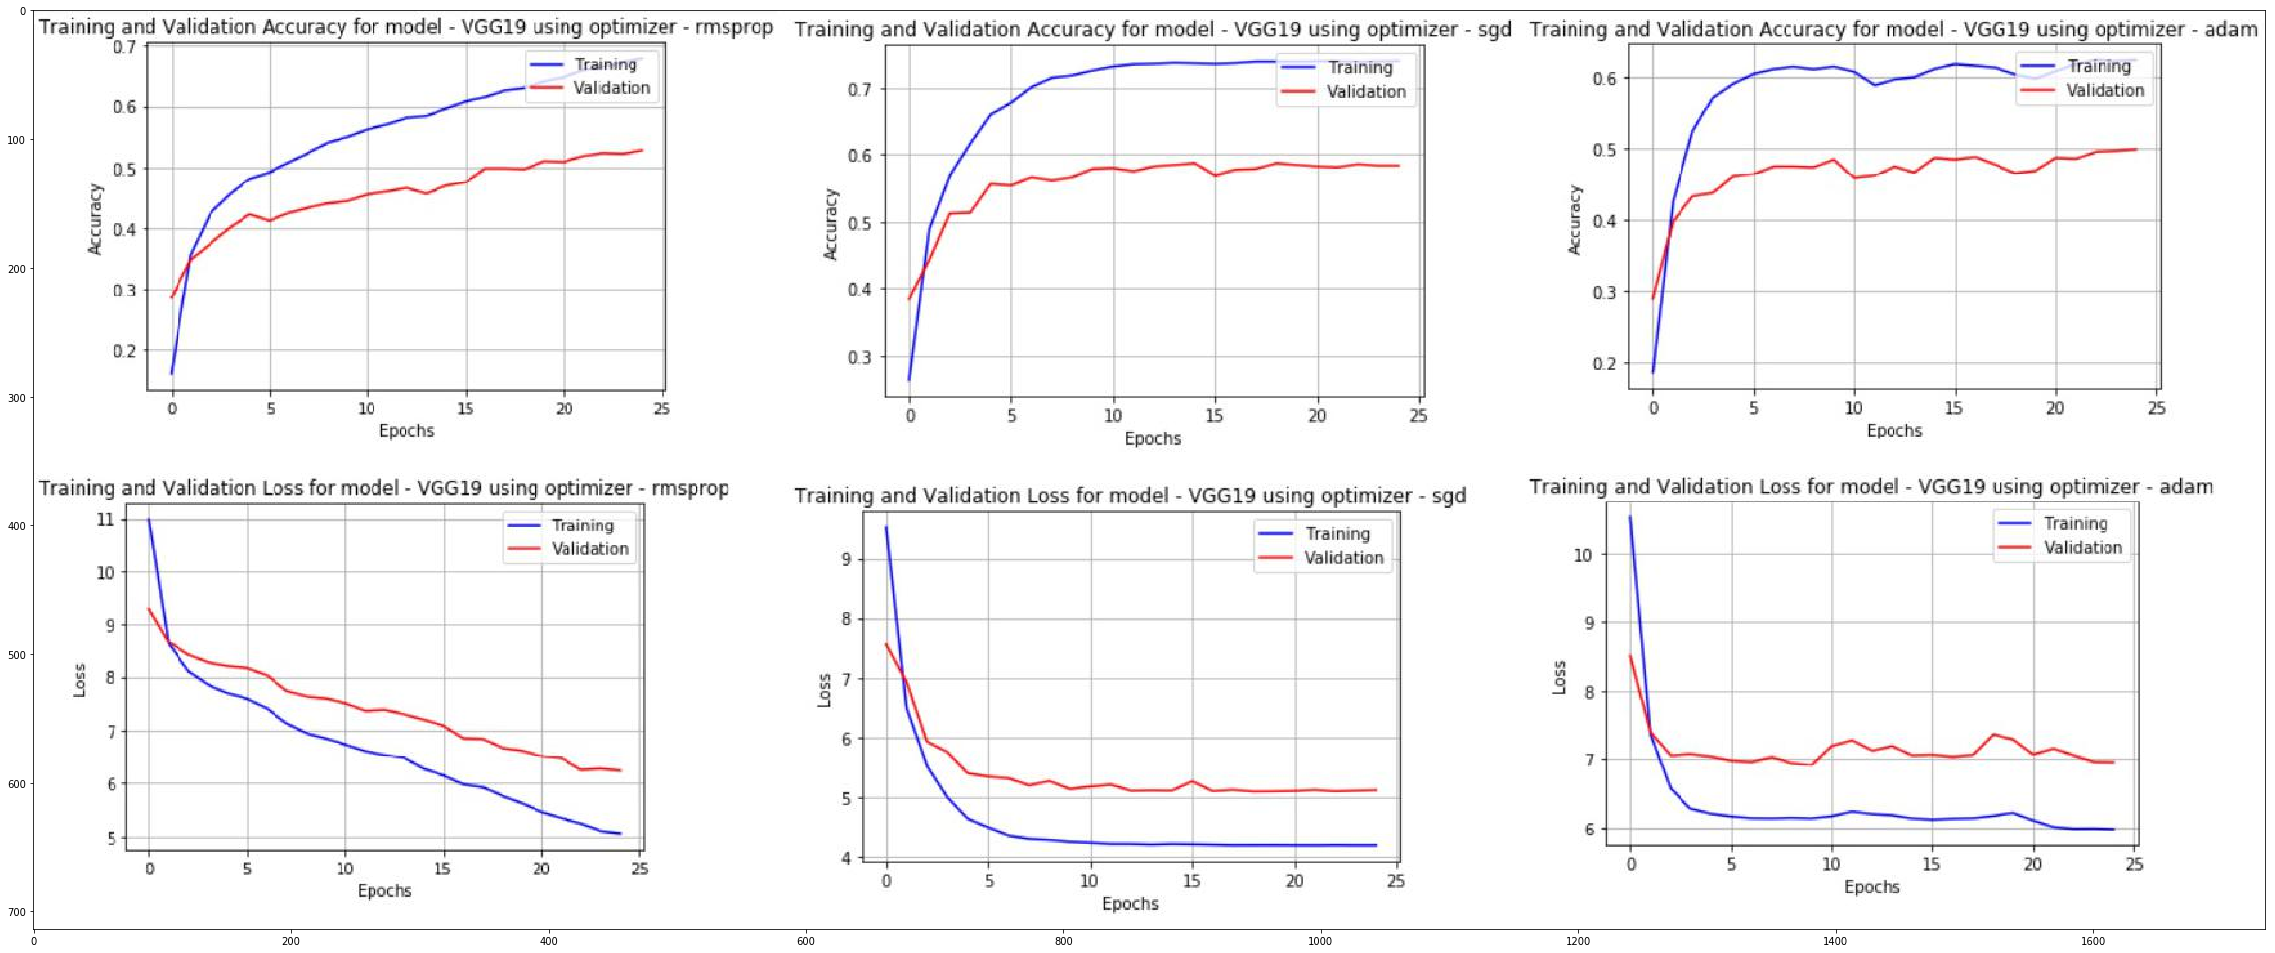

VGG16 Results obtained for optimizer - Rmsprop,SGD,Adam


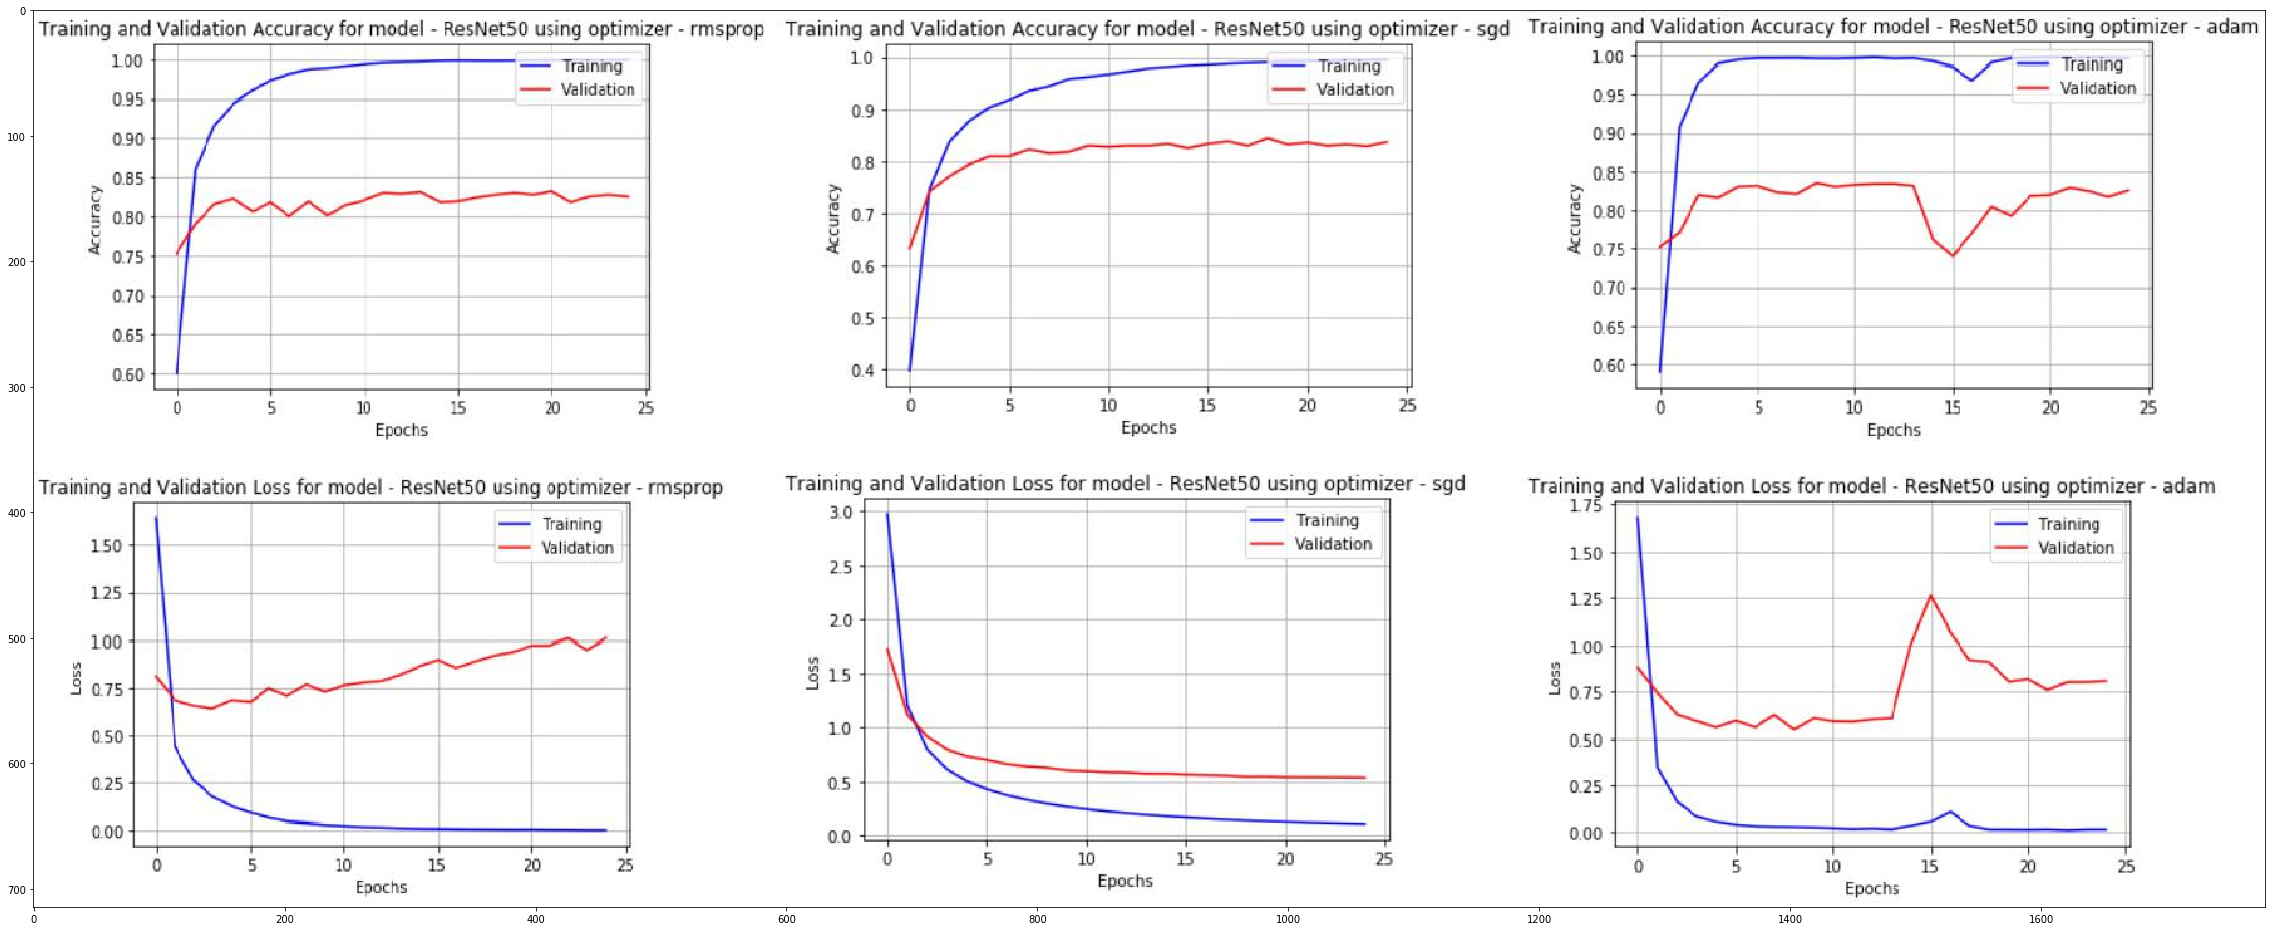

VGG19 Results obtained for optimizer - Rmsprop,SGD,Adam


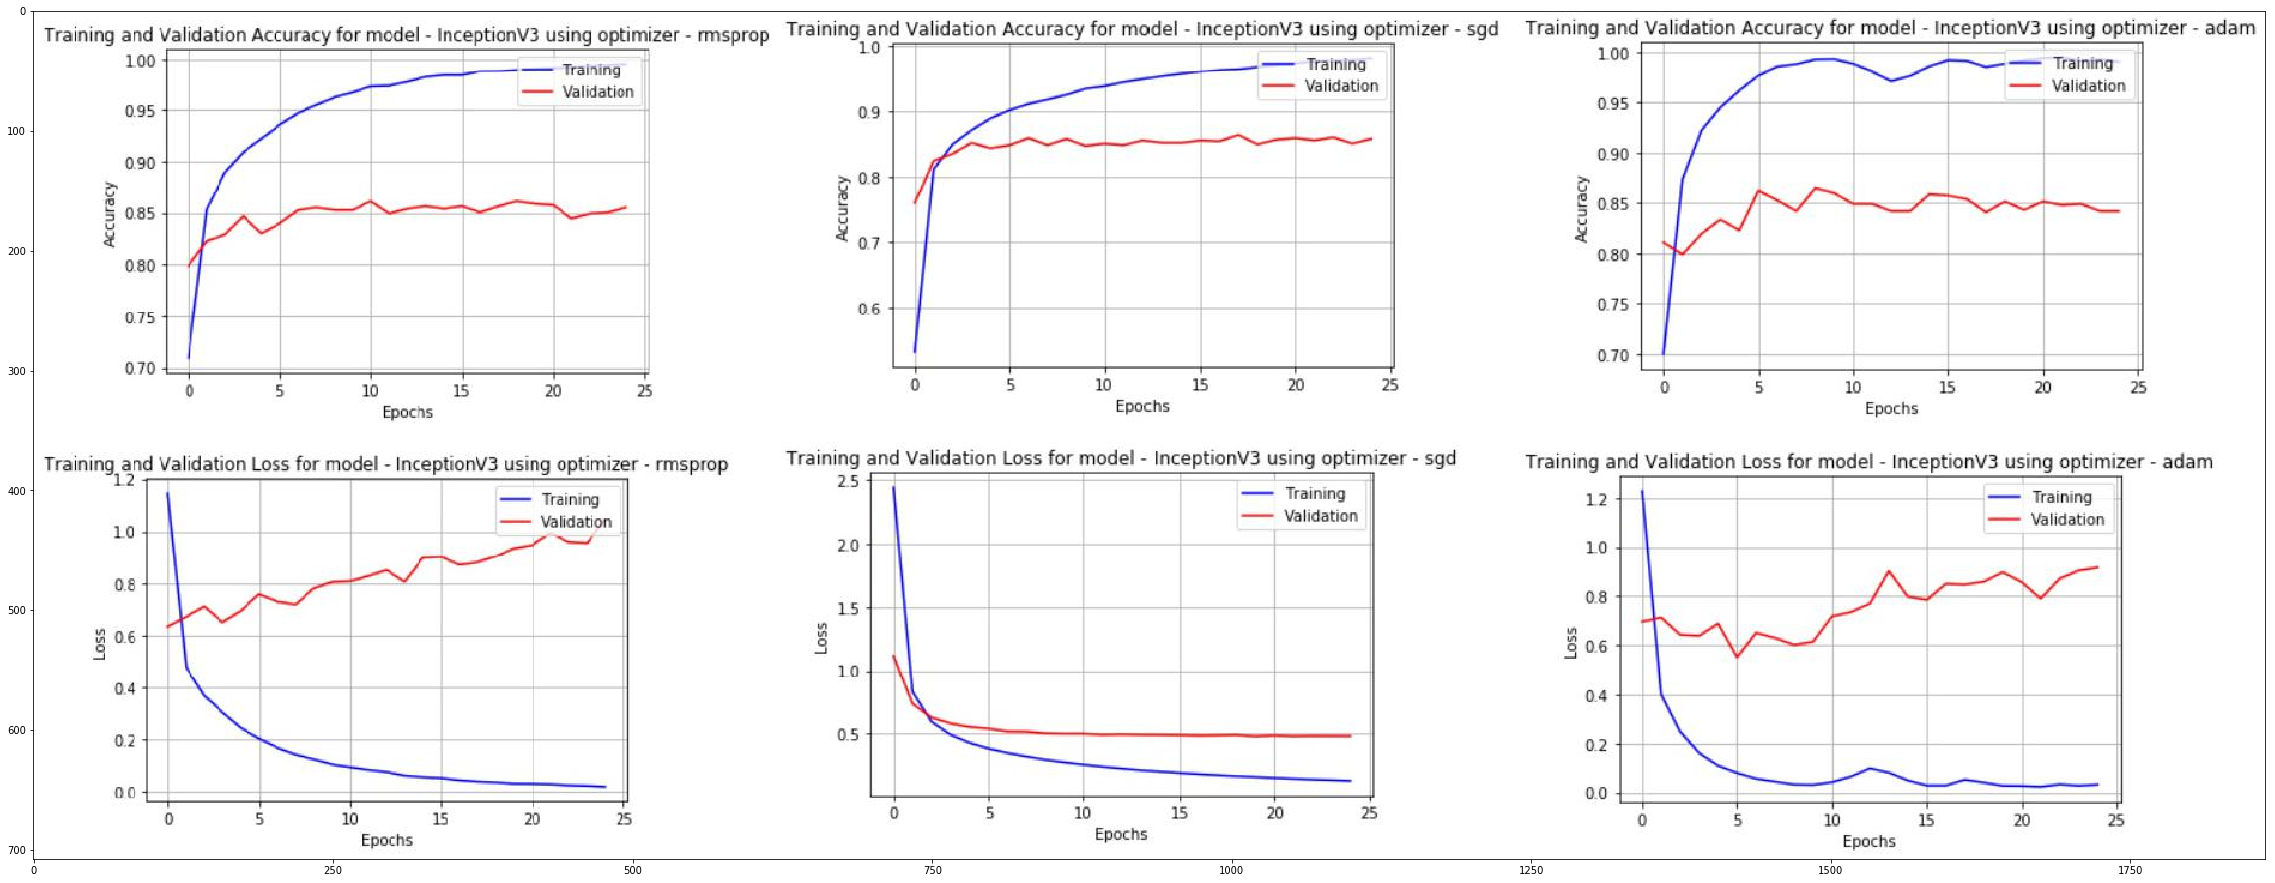

Xception Results obtained for optimizer - Rmsprop,SGD,Adam


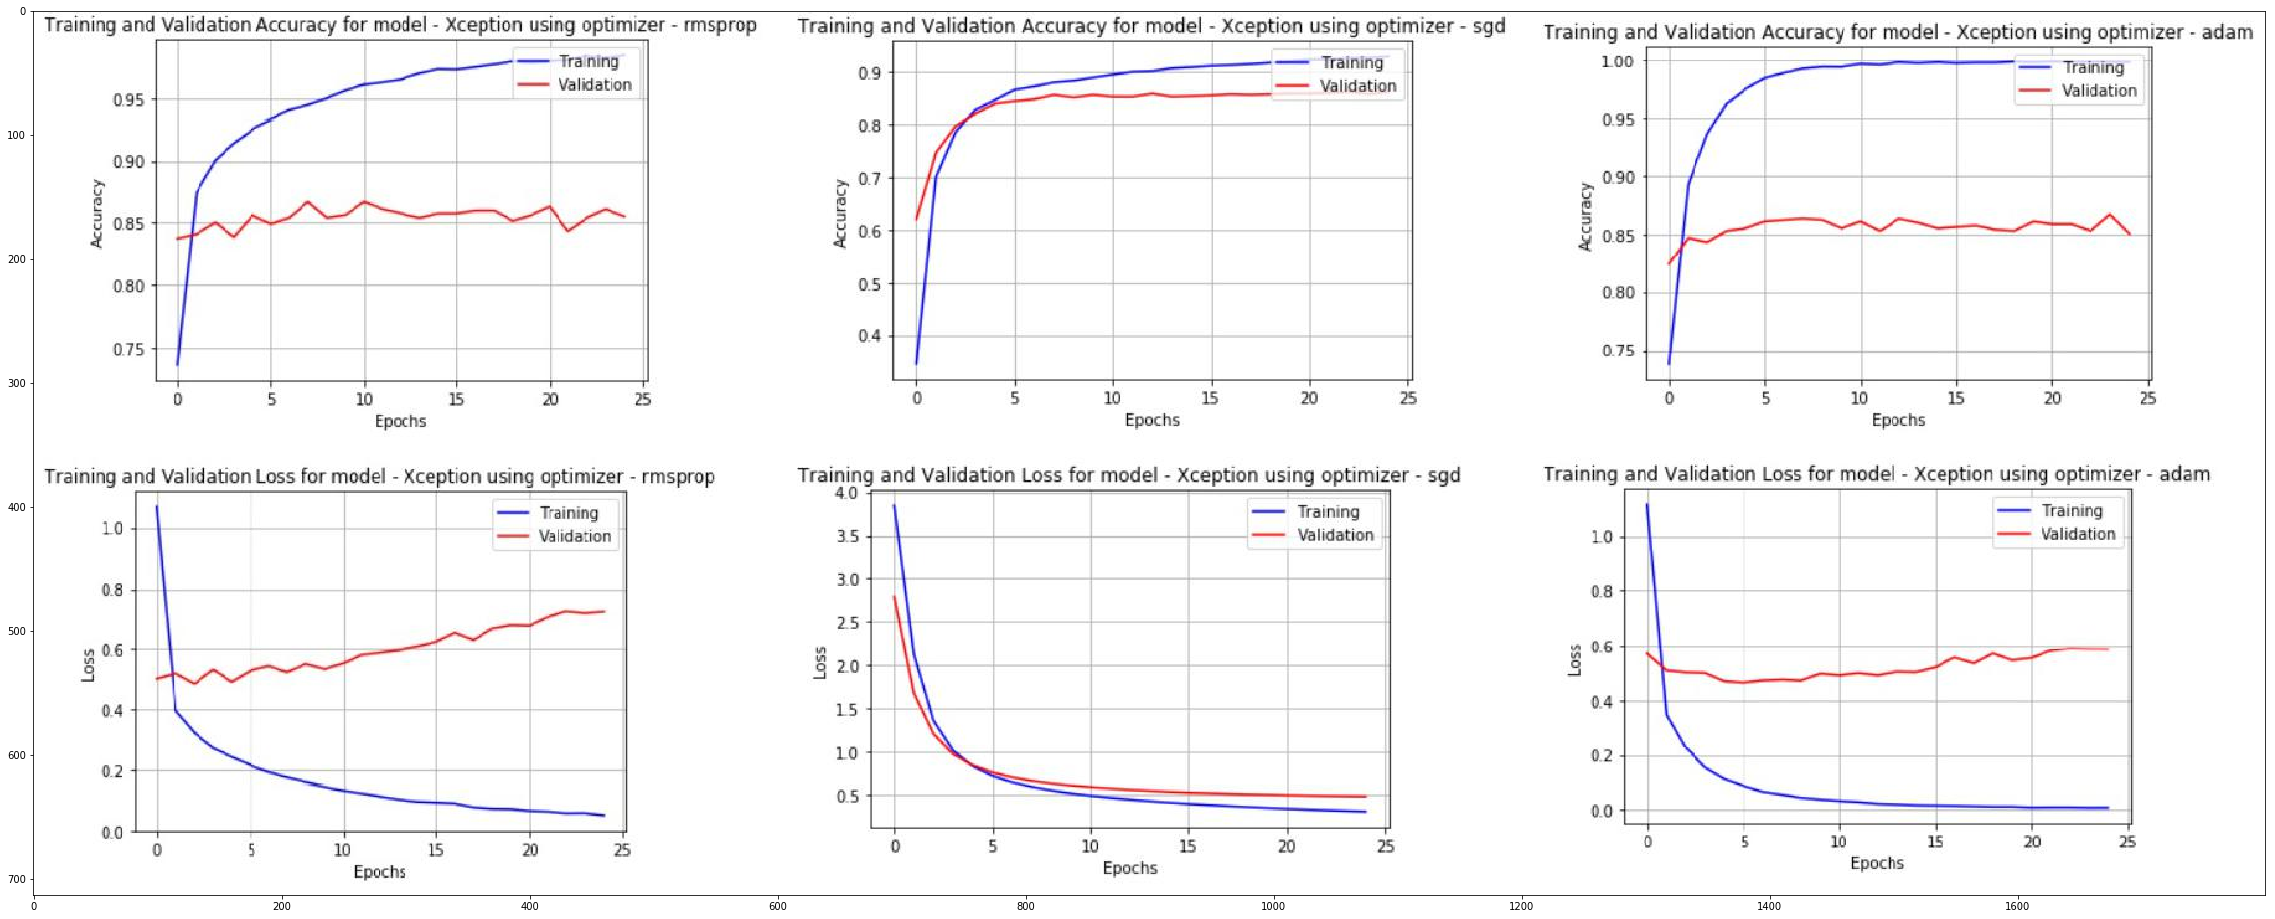

In [30]:
#import glob
#from PIL import Image

#Details of various models for which the code was executed
arrList=['Inception V3 Results obtained for optimizer - Rmsprop,SGD,Adam',
          'ResNet50 Results obtained for optimizer - Rmsprop,SGD,Adam',
          'VGG16 Results obtained for optimizer - Rmsprop,SGD,Adam',
          'VGG19 Results obtained for optimizer - Rmsprop,SGD,Adam',
          'Xception Results obtained for optimizer - Rmsprop,SGD,Adam']

i=0
images=glob("Result_images/*")

#Load all the result images for various models
for im in images:
    pic = cv2.imread(im)
   
    # Convert from BGR to RGB
    cv_rgb = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
    
    # Plot the image
    plt.figure(figsize=(40,55))
    plt.imshow(cv_rgb)
    
    print(arrList[i])
    plt.show() 
    i +=1

In [31]:
import pandas as pd

#Code create array with testing accuracy values
data=[['InceptionV3',78.4689,82.6555,81.5789],
      ['ResNet50',82.2967,84.2105,81.5789],
      ['VGG16',50.2392,60.8852,37.9187],
      ['VGG19',57.6555,59.8086,41.9856],
      ['Xception',84.689,84.8086,85.1675]]
#Code to create dataframe
df = pd.DataFrame(data,columns=['Model','Rmsprop','SGD','Adam'])

print('Testing Accuracy of various models')

#Print the results
df

Testing Accuracy of various models


Model  Rmsprop      SGD     Adam
0  InceptionV3  78.4689  82.6555  81.5789
1     ResNet50  82.2967  84.2105  81.5789
2        VGG16  50.2392  60.8852  37.9187
3        VGG19  57.6555  59.8086  41.9856
4     Xception  84.6890  84.8086  85.1675

Which network should we use to solve the current problem ? 
(Pretrained models to choose from : VGG19,ResNet50,InceptionV3,Xception)

Answer : 
Refer the above graphs-Training and Validation accuracy for each pretrained model with respect to three optimizers: 
The gap between the training and validation accuracy indicates the amount of overfitting.Two possible cases are shown in the 
diagram on the top. 

Category 1 : In this case the validation accuracy is very small compared to the training accuracy, indicating strong 
overfitting. 

Category 2: In this case the validation accuracy tracks the training accuracy fairly well. 

Observation: We observe that the results obtained by using SGD optimizer are much better when compared to the other 
two optimizers (Rmsprop and adam). 

Refer the above graphs- Training and Validation Loss for each pretrained model with respect to three optimizers:
Typically, validation loss should be similar to but slightly higher than training loss.

Category 1 : Overfitting if: training loss << validation loss

Category 2 : Underfitting if: training loss >> validation loss

Category 3 : Just right if training loss ~ validation loss

Observation: We observe that Xception (SGD) ,InceptionV3(SGD) and ResNet50(SGD) perfectly fits in the Category 3. 

Conclusion: If we compare the test accuracy and the above observations Xception (SGD) seems to be a perfect option which 
can be used in the current scenario.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

We basically create a model-final CNN architecture that takes an array (7,7,2048) from Xception -bottleneck features.

Line 2 : Here we do some dimensionality reduction through a global average pooling layer(gap layer).It greatly reduces the no of parameters that we need to train 

Network_model.add(GlobalAveragePooling2D(input_shape=train_network.shape[1:]))

Line 3: We add a new classification layer with 133 nodes (i.e. we have around 133 categories of dogs).We then train only the weights in this layer, freezing all the weights in other layers.

Network_model.add(Dense(133, activation='softmax'))

In this case the model is truly benefitted from the headstart that it was given from pretraining on Imagenet.This technique will work well since our dataset is very similar and relatively smaller(around 8351 dog images only) compared to ImageNet dataset.

In [32]:
### TODO: Define your architecture.

Network_model = Sequential()
Network_model.add(GlobalAveragePooling2D(input_shape=train_network.shape[1:]))
Network_model.add(Dense(133, activation='softmax'))  
Network_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [33]:
### TODO: Compile the model.
optimizer='sgd'
Network_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [34]:
from keras.callbacks import ModelCheckpoint 
### TODO: Train the model.

#Code to set values for batch size and epochs
batch_size=20
epochs=25

filepath = 'saved_models/weights.best.' + network + '.hdf5'
checkpointer = ModelCheckpoint(filepath=filepath, 
                               verbose=1, save_best_only=True)

Network_model_hist=Network_model.fit(train_network, train_targets, 
          validation_data=(valid_network, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=0)


Epoch 00001: val_loss improved from inf to 2.77884, saving model to saved_models/weights.best.Xception.hdf5

Epoch 00002: val_loss improved from 2.77884 to 1.67055, saving model to saved_models/weights.best.Xception.hdf5

Epoch 00003: val_loss improved from 1.67055 to 1.20168, saving model to saved_models/weights.best.Xception.hdf5

Epoch 00004: val_loss improved from 1.20168 to 0.97556, saving model to saved_models/weights.best.Xception.hdf5

Epoch 00005: val_loss improved from 0.97556 to 0.84630, saving model to saved_models/weights.best.Xception.hdf5

Epoch 00006: val_loss improved from 0.84630 to 0.76463, saving model to saved_models/weights.best.Xception.hdf5

Epoch 00007: val_loss improved from 0.76463 to 0.70662, saving model to saved_models/weights.best.Xception.hdf5

Epoch 00008: val_loss improved from 0.70662 to 0.66463, saving model to saved_models/weights.best.Xception.hdf5

Epoch 00009: val_loss improved from 0.66463 to 0.63370, saving model to saved_models/weights.best.X

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [35]:
### TODO: Load the model weights with the best validation loss.
Network_model.load_weights(filepath)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [36]:
### TODO: Calculate classification accuracy on the test dataset.
Network_model_predictions = [np.argmax(Network_model.predict(np.expand_dims(feature, axis=0))) for feature in test_network]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Network_model_predictions)==np.argmax(test_targets, axis=1))/len(Network_model_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 84.2105%


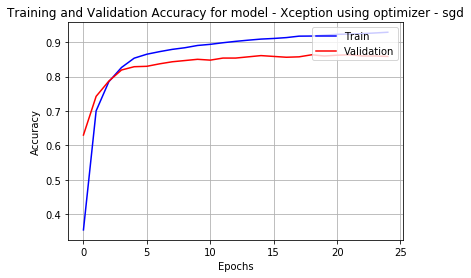

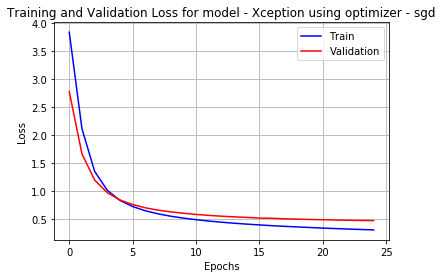

In [37]:
#Display Training and Validation Accuracy / Loss as graph
graph1title = 'Training and Validation Accuracy for model - '+str(network) +' using optimizer - '+str(optimizer)
graph2title = 'Training and Validation Loss for model - '+str(network) +' using optimizer - '+str(optimizer)

display_graph(Network_model_hist,graph1title,'Epochs','Accuracy','acc','val_acc')
display_graph(Network_model_hist,graph2title,'Epochs','Loss','loss','val_loss')


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [38]:
from extract_bottleneck_features import *
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
   
def network_predict_breed(img_path):
    
    # extract bottleneck features corresponding to the specified option
    if network =='VGG19':
        bottleneck_feature = extract_VGG19(path_to_tensor(img_path))
    elif network =='ResNet50':
        bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    elif network == 'InceptionV3':
        bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    elif network =='Xception':
        bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    
    # obtain predicted vector
    predicted_vector = Network_model.predict(bottleneck_feature)
    
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [39]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def dog_breed_predictor(image_path):
    
    
     # Use same Image Pipeline as used earlier
    img = cv2.imread(image_path)
    # Convert from BGR to RGB
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Plot the image
    plt.imshow(cv_rgb)
    plt.show()
     
    breed = network_predict_breed(image_path)
    
    #Call dog detector function
    if dog_detector(image_path):
        print("A dog has been detected!! It's breed is : "+str(breed))
    #Call face detector function
    elif face_detector(image_path):
        print("A human has been detected! You look like a " +str(breed))
  
    else:
        print("Error: Neither a human or a dog was detected.Please provide another image\n")
    return  



---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The algorithm performed pretty well but not as per my expectations. All the images which had dogs in it were identified correctly and the breed was successfully predicted. I was quite impressed when the algorithm was able to identify a human even though the image was blurred. It was also able to identify a human with a beard. But on the other hand, it was unable to identify the image which had a human wearing sunglass. Also, it identified a cat image as a human.

Few improvements that can be made are as listed as follows: 
1.	Different model architectures can be explored to minimizing prediction time while maintaining accuracy. 
2.	Apply augmentation technique on the training and validation data.
3.	The algorithm also needs to be trained so that it can identify mixed breeds correctly. Train the algorithm to enable it to recognise humans(wearing sunglass) correctly.

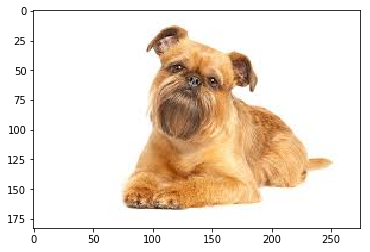

A dog has been detected!! It's breed is : Brussels_griffon


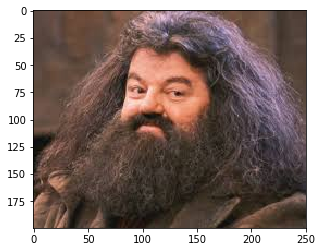

A human has been detected! You look like a Irish_water_spaniel


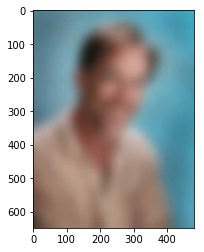

A human has been detected! You look like a Petit_basset_griffon_vendeen


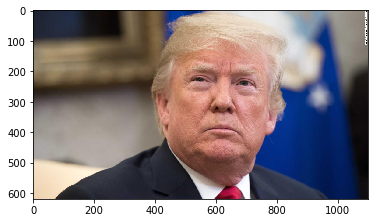

A human has been detected! You look like a Portuguese_water_dog


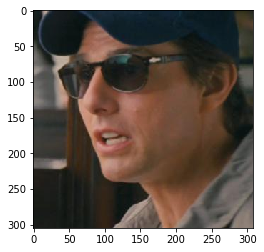

Error: Neither a human or a dog was detected.Please provide another image



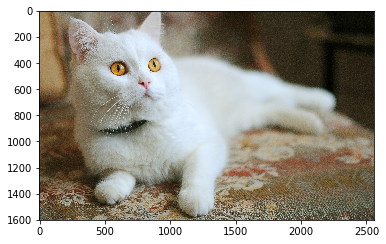

A human has been detected! You look like a Japanese_chin


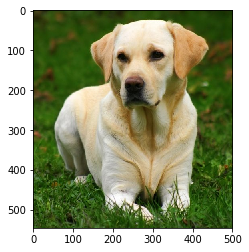

A dog has been detected!! It's breed is : Labrador_retriever


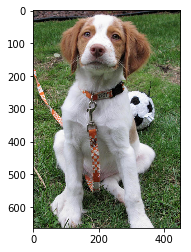

A dog has been detected!! It's breed is : Brittany


In [40]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## Load the cell
sample_files = np.array(glob("sample_images/*"))
#print(sample_files)

for path in sample_files:
    dog_breed_predictor(path)